In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine, plot_bootstrap_timeseries
from phase_precession import cl_corr
from spike_statistics.core import permutation_resampling
import matplotlib.mlab as mlab
import scipy.signal as ss
from scipy.interpolate import interp1d
from septum_mec.analysis.plotting import regplot
from skimage import measure
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import scipy.signal as ss


from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

import pycwt

/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  r

In [3]:
control_color = '#4393c3'
chabc_color = '#d6604d'
control_novel_color = '#4393c3'
chabc_novel_color = '#d6604d'

plt.rcParams['figure.dpi'] = 150
figsize_violin = (1.7, 3)
figsize_speed = (4, 3)
plt.rc('axes', titlesize=10)

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "lfp_speed"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [5]:
data_action = actions['lfp_speed']
output = exdir.File(
    data_action.data_path('results'),
    plugins = [exdir.plugins.git_lfs, exdir.plugins.quantities])

ignore = ['wavelet_power', 'wavelet_freqs', 'signal']
results = []
for group in output.values():
    d = group.attrs.to_dict()
    d.update({k: np.array(v.data) for k, v in group.items() if k not in ignore})
    results.append(d)
results = pd.DataFrame(results)

In [6]:
results.head()

,action,channel_id,eeg,freq_score,max_speed,mean_freq,mean_power,min_speed,position_low_pass_frequency,power_score,psd,psd_freqs,sample_rate,speed,speed_bins,theta_freq,theta_power
0,1346-030813-01,0,1,0.131380,1,"[7.724918522542083, 7.668021164021152, 7.62638...","[6.147102572333352, 5.078868288997023, 4.35973...",0.02,6,0.044689,"[0.05678286943862452, 0.16443651574717702, 0.1...","[0.0, 0.12159533073929961, 0.24319066147859922...",250,"[0.0177747767547335, 0.022750706177890836, 0.0...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[7.899999999999986, 7.899999999999986, 7.89999...","[2.4506492518185983, 2.4574510707142396, 2.464..."
1,1346-030813-01,4,2,0.109615,1,"[7.01386474741987, 7.121005291005281, 7.215250...","[2.44892560650099, 2.417650998784653, 2.351765...",0.02,6,0.112595,"[0.1510081655508016, 0.4569807728609823, 0.457...","[0.0, 0.12159533073929961, 0.24319066147859922...",250,"[0.0177747767547335, 0.022750706177890836, 0.0...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[7.899999999999986, 7.899999999999986, 7.99999...","[0.8082599362945555, 0.8104768807923804, 0.812..."
2,1346-050813-01,0,1,0.209466,1,"[7.521631888710528, 7.457859632514296, 7.44558...","[3.6085873518447666, 3.8087280997871735, 3.948...",0.02,6,0.446154,"[0.1960946700566803, 0.38399009180405724, 0.37...","[0.0, 0.12159533073929961, 0.24319066147859922...",250,"[0.3653836497087306, 0.3663051771687342, 0.365...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[7.999999999999986, 7.999999999999986, 7.99999...","[2.2562369168220333, 2.2634765577648737, 2.270..."
3,1346-050813-01,4,2,0.117109,1,"[7.121599785981797, 7.133753603855576, 7.14259...","[2.450927620358271, 2.5843934810576377, 2.5683...",0.02,6,0.090298,"[0.04758445725413012, 0.19523785849243636, 0.2...","[0.0, 0.12159533073929961, 0.24319066147859922...",250,"[0.3653836497087306, 0.3663051771687342, 0.365...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[7.499999999999988, 7.499999999999988, 7.49999...","[1.4643069399437678, 1.4685951400412054, 1.472..."
4,1346-130713-01,2,1,0.074698,1,"[7.153658299752381, 7.257453136617998, 7.33855...","[3.6638501534771093, 3.7535551504994737, 3.834...",0.02,6,0.123524,"[0.017516271102976457, 0.0549155232491452, 0.0...","[0.0, 0.12159533073929961, 0.24319066147859922...",250,"[0.15217540789344478, 0.15005180397385187, 0.1...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[7.7999999999999865, 7.7999999999999865, 7.799...","[1.9659556633107798, 1.9720539458347823, 1.978..."


# Frequency score

U-test: U value 3100.0 p value 7.397343828092893e-08


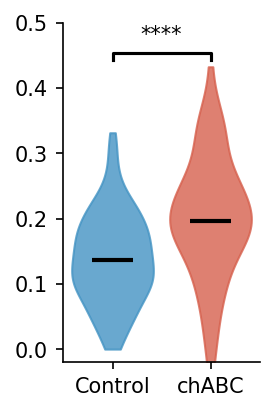

In [12]:
stuff = 'freq_score'
ctrl = results.query('baseline and Hz11')[stuff].to_numpy()
stim = results.query('stimulated and Hz11')[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(ctrl, stim)
plt.ylim(-0.02, 0.5)
plt.savefig(output_path / "figures" / "frequency_score.svg", bbox_inches="tight", transparent=True)
plt.savefig(output_path / "figures" / "frequency_score.png", bbox_inches="tight", transparent=True)

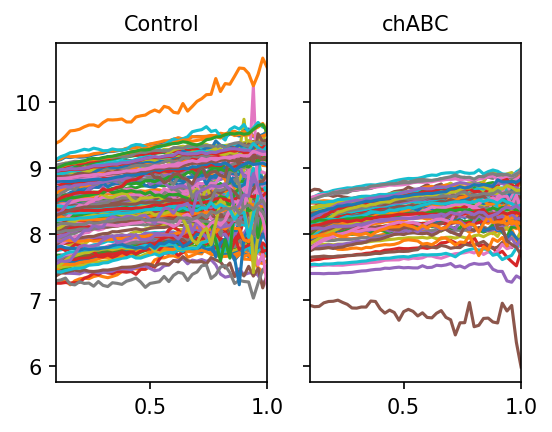

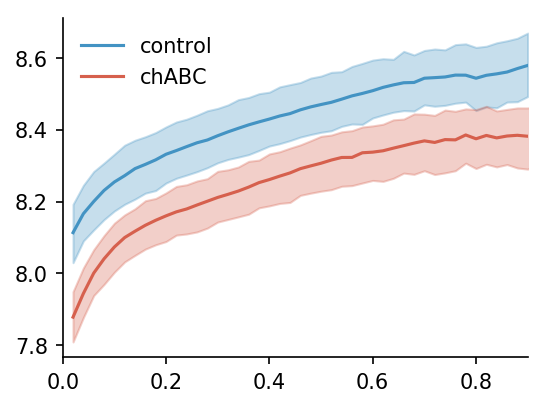

In [13]:
stuff = 'mean_freq'
chabc = np.array([s for s in sessions.query(query_familiar)[stuff]])
chabc_bins = sessions.query(query_familiar)['speed_bins'].to_numpy()

ctrl = np.array([s for s in sessions.query('not ' + query_familiar)[stuff]])
ctrl_bins = sessions.query('not ' + query_familiar)['speed_bins'].to_numpy()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)

for b, h in zip(ctrl_bins, ctrl):
    axs[0].plot(b, h)
    axs[0].set_xlim(0.1,1)
    axs[0].set_title('Control')
    
for b, h in zip(chabc_bins, chabc):
    axs[1].plot(b, h)
    axs[1].set_xlim(0.1,1)
    axs[1].set_title('chABC')
    

fig, ax = plt.subplots(1, 1, figsize=figsize_speed)

plot_bootstrap_timeseries(ctrl_bins[0], ctrl, ax=ax, label='control', color=control_color)
plot_bootstrap_timeseries(chabc_bins[0], chabc, ax=ax, label='chABC', color=chabc_color)
plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)

plt.savefig(output_path / "figures" / "mean_frequency_familiar.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_frequency_familiar.png", bbox_inches="tight", transparent=True)

# Power Familiar

U-test: U value 2800.0 p value 1.5382344745456174e-09


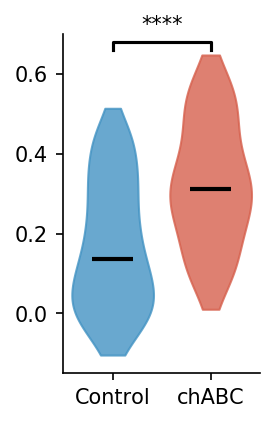

In [14]:
stuff = 'power_score'
chabc = sessions.query(query_familiar)[stuff].to_numpy()
ctrl = sessions.query('not ' + query_familiar)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(ctrl, chabc)
plt.ylim(-0.15, 0.7)

plt.savefig(output_path / "figures" / "power_familiar_violin.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "power_familiar_violin.png", bbox_inches="tight", transparent=True)

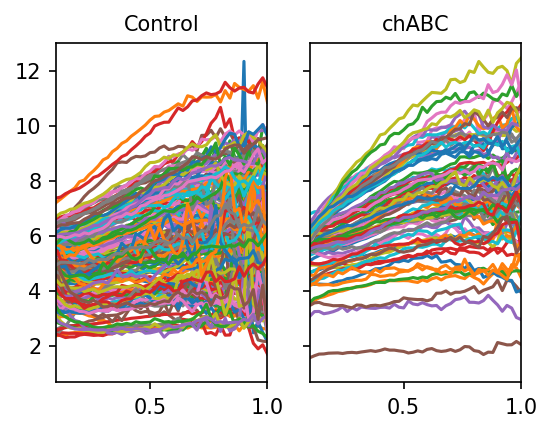

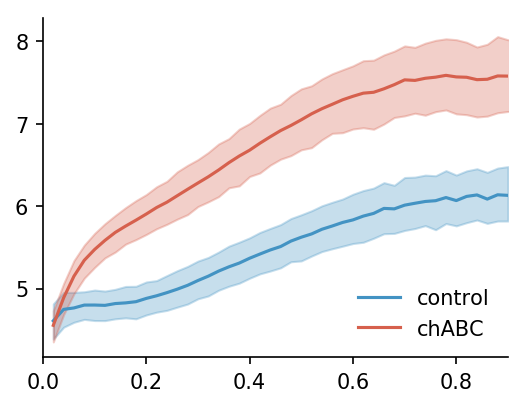

In [15]:
stuff = 'mean_power'
chabc = np.array([a for a in sessions.query(query_familiar)[stuff]])
chabc_bins = sessions.query(query_familiar)['speed_bins'].to_numpy()

ctrl = np.array([a for a in sessions.query('not ' + query_familiar)[stuff]])
ctrl_bins = sessions.query('not ' + query_familiar)['speed_bins'].to_numpy()


fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)
axs = axs.ravel()

for b, h in zip(ctrl_bins, ctrl):
    axs[0].plot(b, h)
    axs[0].set_xlim(0.1,1)
    axs[0].set_title('Control')
    
for b, h in zip(chabc_bins, chabc):
    axs[1].plot(b, h)
    axs[1].set_xlim(0.1,1)
    axs[1].set_title('chABC')
    
    
fig, ax = plt.subplots(1, 1, figsize=figsize_speed)

plot_bootstrap_timeseries(ctrl_bins[0], ctrl, ax=ax, label='control', color=control_color)
plot_bootstrap_timeseries(chabc_bins[0], chabc, ax=ax, label='chABC', color=chabc_color)
plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, loc='lower right')

plt.savefig(output_path / "figures" / "mean_power_familiar.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_power_familiar.png", bbox_inches="tight", transparent=True)

# Frequency Novel

U-test: U value 200.0 p value 0.0015787273193761367


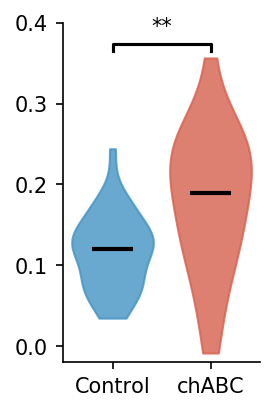

In [16]:
stuff = 'freq_score'
chabc = sessions.query(query_novel)[stuff].to_numpy()
ctrl = sessions.query('not ' + query_novel)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(ctrl, chabc)
plt.ylim(-0.02, 0.4)
plt.savefig(output_path / "figures" / "frequency_novel_violin.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "frequency_novel_violin.png", bbox_inches="tight", transparent=True)

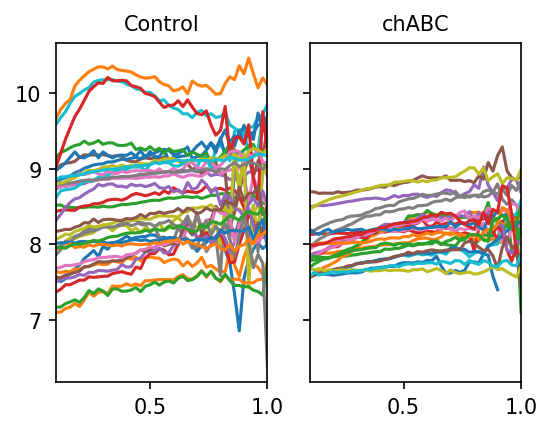

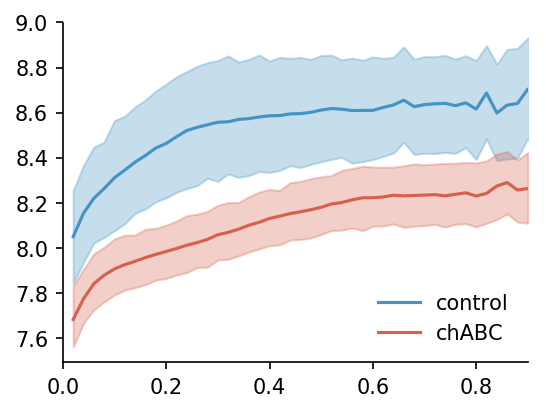

In [17]:
stuff = 'mean_freq'
chabc = np.array([a for a in sessions.query(query_novel)[stuff]])
chabc_bins = sessions.query(query_novel)['speed_bins'].to_numpy()

ctrl = np.array([a for a in sessions.query('not ' + query_novel)[stuff]])
ctrl_bins = sessions.query('not ' + query_novel)['speed_bins'].to_numpy()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)

for b, h in zip(ctrl_bins, ctrl):
    axs[0].plot(b, h)
    axs[0].set_xlim(0.1,1)
    axs[0].set_title('Control')
    
for b, h in zip(chabc_bins, chabc):
    axs[1].plot(b, h)
    axs[1].set_xlim(0.1,1)
    axs[1].set_title('chABC')
    
fig, ax = plt.subplots(1, 1, figsize=figsize_speed)

plot_bootstrap_timeseries(ctrl_bins[0], ctrl, ax=ax, label='control', color=control_color)
plot_bootstrap_timeseries(chabc_bins[0], chabc, ax=ax, label='chABC', color=chabc_color)
plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, loc='lower right')

plt.savefig(output_path / "figures" / "mean_frequency_novel.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_frequency_novel.png", bbox_inches="tight", transparent=True)

# Power Novel

U-test: U value 102.0 p value 2.0979380574803542e-06


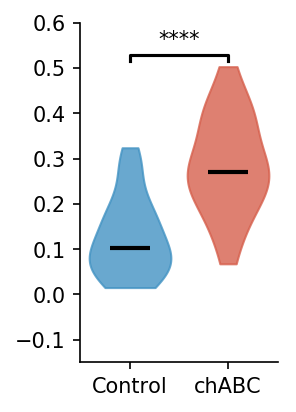

In [18]:
stuff = 'power_score'
chabc = sessions.query(query_novel)[stuff].to_numpy()
ctrl = sessions.query('not ' + query_novel)[stuff].to_numpy()
plt.figure(figsize=figsize_violin)
violinplot(ctrl, chabc)
plt.ylim(-0.15, 0.6)
plt.savefig(output_path / "figures" / "power_novel_violin.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "power_novel_violin.png", bbox_inches="tight", transparent=True)

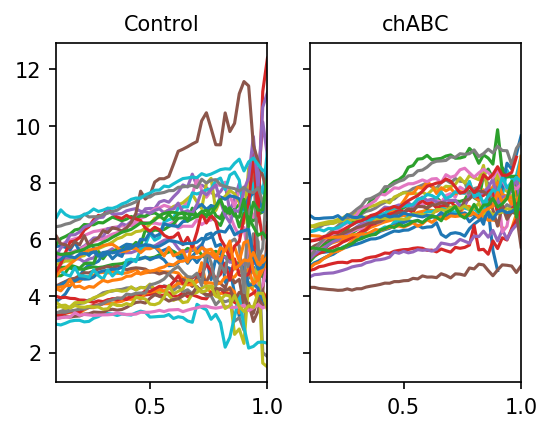

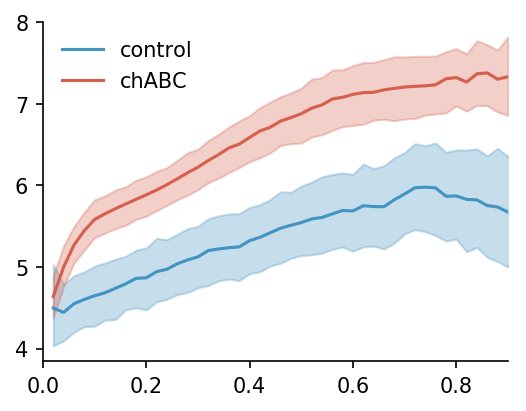

In [19]:
stuff = 'mean_power'
chabc = np.array([a for a in sessions.query(query_novel)[stuff]])
chabc_bins = sessions.query(query_novel)['speed_bins'].to_numpy()

ctrl = np.array([a for a in sessions.query('not ' + query_novel)[stuff]])
ctrl_bins = sessions.query('not ' + query_novel)['speed_bins'].to_numpy()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)

for b, h in zip(ctrl_bins, ctrl):
    axs[0].plot(b, h)
    axs[0].set_xlim(0.1,1)
    axs[0].set_title('Control')
    
for b, h in zip(chabc_bins, chabc):
    axs[1].plot(b, h)
    axs[1].set_xlim(0.1,1)
    axs[1].set_title('chABC')
    
fig, ax = plt.subplots(1, 1, figsize=figsize_speed)

plot_bootstrap_timeseries(ctrl_bins[0], ctrl, ax=ax, label='control', color=control_color)
plot_bootstrap_timeseries(chabc_bins[0], chabc, ax=ax, label='chABC', color=chabc_color)
plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)

plt.savefig(output_path / "figures" / "mean_power_novel.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_power_novel.png", bbox_inches="tight", transparent=True)

# Overlap

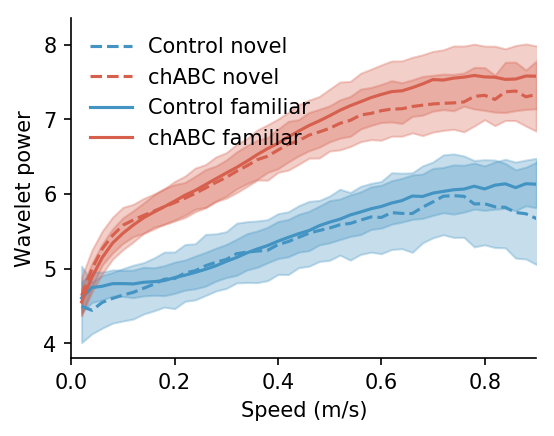

In [22]:
fig, ax = plt.subplots(1, 1, figsize=figsize_speed)


stuff = 'mean_power'

# Novel
chabc_novel = np.array([a for a in sessions.query(query_novel)[stuff]])
chabc_bins_novel = sessions.query(query_novel)['speed_bins'].to_numpy()

ctrl_novel = np.array([a for a in sessions.query('not ' + query_novel)[stuff]])
ctrl_bins_novel = sessions.query('not ' + query_novel)['speed_bins'].to_numpy()

plot_bootstrap_timeseries(
    ctrl_bins_novel[0], ctrl_novel, ax=ax, label='Control novel', color=control_color, ls='--')
plot_bootstrap_timeseries(
    chabc_bins_novel[0], chabc_novel, ax=ax, label='chABC novel', color=chabc_color, ls='--')

# Familiar
chabc_familiar = np.array([a for a in sessions.query(query_familiar)[stuff]])
chabc_bins_familiar = sessions.query(query_familiar)['speed_bins'].to_numpy()

ctrl_familiar = np.array([a for a in sessions.query('not ' + query_familiar)[stuff]])
ctrl_bins_familiar = sessions.query('not ' + query_familiar)['speed_bins'].to_numpy()

plot_bootstrap_timeseries(
    ctrl_bins_familiar[0], ctrl_familiar, ax=ax, label='Control familiar', color=control_color)
plot_bootstrap_timeseries(
    chabc_bins_familiar[0], chabc_familiar, ax=ax, label='chABC familiar', color=chabc_color)


plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.ylabel('Wavelet power')
plt.xlabel('Speed (m/s)')

plt.savefig(output_path / "figures" / "mean_power_overlap.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_power_overlap.png", bbox_inches="tight", transparent=True)

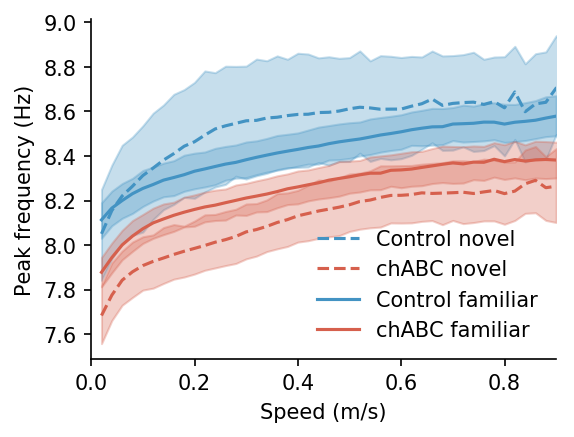

In [23]:
fig, ax = plt.subplots(1, 1, figsize=figsize_speed)
stuff = 'mean_freq'

# Novel
chabc_novel = np.array([a for a in sessions.query(query_novel)[stuff]])
chabc_bins_novel = sessions.query(query_novel)['speed_bins'].to_numpy()

ctrl_novel = np.array([a for a in sessions.query('not ' + query_novel)[stuff]])
ctrl_bins_novel = sessions.query('not ' + query_novel)['speed_bins'].to_numpy()

plot_bootstrap_timeseries(
    ctrl_bins_novel[0], ctrl_novel, ax=ax, label='Control novel', color=control_color, ls='--')
plot_bootstrap_timeseries(
    chabc_bins_novel[0], chabc_novel, ax=ax, label='chABC novel', color=chabc_color, ls='--')

# Familiar
chabc_familiar = np.array([a for a in sessions.query(query_familiar)[stuff]])
chabc_bins_familiar = sessions.query(query_familiar)['speed_bins'].to_numpy()

ctrl_familiar = np.array([a for a in sessions.query('not ' + query_familiar)[stuff]])
ctrl_bins_familiar = sessions.query('not ' + query_familiar)['speed_bins'].to_numpy()

plot_bootstrap_timeseries(
    ctrl_bins_familiar[0], ctrl_familiar, ax=ax, label='Control familiar', color=control_color)
plot_bootstrap_timeseries(
    chabc_bins_familiar[0], chabc_familiar, ax=ax, label='chABC familiar', color=chabc_color)

plt.xlim(0, 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.ylabel('Peak frequency (Hz)')
plt.xlabel('Speed (m/s)')

plt.savefig(output_path / "figures" / "mean_frequency_overlap.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "mean_frequency_overlap.png", bbox_inches="tight", transparent=True)

# Speed

U-test: U value 5672.0 p value 0.7895263962829568


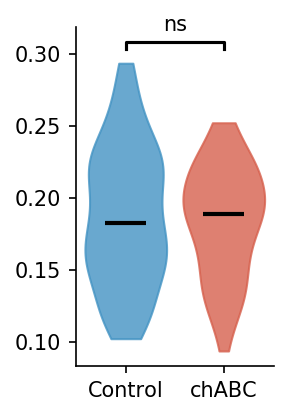

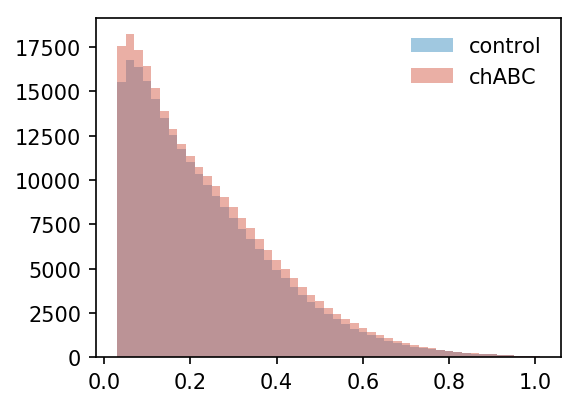

In [40]:
stuff = 'speed'
min_speed = sessions['min_speed'].iloc[0]
max_speed = sessions['max_speed'].iloc[0]

f = np.median
chabc = np.array([f(a) for a in sessions.query(query_familiar)[stuff]])
ctrl = np.array([f(a).mean() for a in sessions.query('not ' + query_familiar)[stuff]])
plt.figure(figsize=figsize_violin)
violinplot(ctrl, chabc)

plt.figure(figsize=figsize_speed)
binsize = 0.02
bins = np.arange(min_speed, max_speed + binsize, binsize)
chabc = np.array([np.histogram(a, bins)[0] for a in sessions.query(query_familiar)[stuff]])
ctrl = np.array([np.histogram(a, bins)[0]  for a in sessions.query('not ' + query_familiar)[stuff]])

plt.bar(bins[1:], ctrl.mean(axis=0), width=np.diff(bins)[0], label='control', alpha=.5, color=control_color);
plt.bar(bins[1:], chabc.mean(axis=0), width=np.diff(bins)[0], label='chABC', alpha=.5, color=chabc_color);

plt.legend(frameon=False)

plt.savefig(output_path / "figures" / "speed_familiar_histogram.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "speed_familiar_histogram.png", bbox_inches="tight", transparent=True)

U-test: U value 520.0 p value 0.04587089529929454


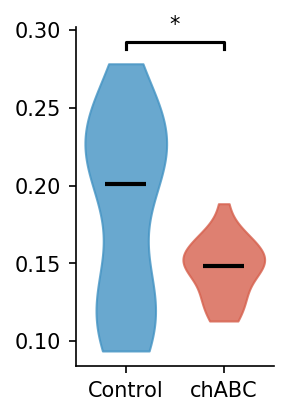

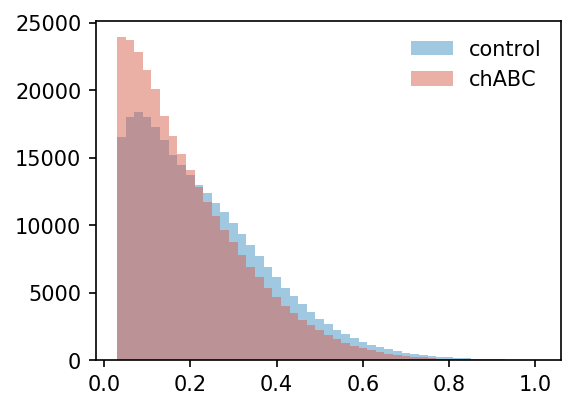

In [41]:
stuff = 'speed'

plt.figure(figsize=figsize_violin)
f = np.median
chabc = np.array([f(a) for a in sessions.query(query_novel)[stuff]])
ctrl = np.array([f(a).mean() for a in sessions.query('not ' + query_novel)[stuff]])
violinplot(ctrl, chabc)

plt.figure(figsize=figsize_speed)
binsize = 0.02
bins = np.arange(min_speed, max_speed + binsize, binsize)
chabc = np.array([np.histogram(a, bins)[0] for a in sessions.query(query_novel)[stuff]])
ctrl = np.array([np.histogram(a, bins)[0]  for a in sessions.query('not ' + query_novel)[stuff]])
plt.bar(bins[1:], ctrl.mean(axis=0), width=np.diff(bins)[0], label='control', alpha=.5, color=control_color);
plt.bar(bins[1:], chabc.mean(axis=0), width=np.diff(bins)[0], label='chABC', alpha=.5, color=chabc_color);

plt.legend(frameon=False)

plt.savefig(output_path / "figures" / "speed_novel_histogram.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "speed_novel_histogram.png", bbox_inches="tight", transparent=True)

# Table

In [44]:
columns = [
    'psd_theta_peak',
    'psd_theta_peak_freq',
    'power_score',
    'freq_score'
]


def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


summary_familiar = pd.DataFrame()

summary_familiar['Control'] = sessions.query('not {}'.format(query_familiar))[columns].agg(summarize)
summary_familiar['chABC'] = sessions.query('{}'.format(query_familiar))[columns].agg(summarize)

summary_novel = pd.DataFrame()

summary_novel['Control'] = sessions.query('not {}'.format(query_novel))[columns].agg(summarize)
summary_novel['chABC'] = sessions.query('{}'.format(query_novel))[columns].agg(summarize)


def MWU(column, query):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        sessions.query('not {}'.format(query))[column].dropna(), 
        sessions.query('{}'.format(query))[column].dropna(),
        alternative='two-sided')
    
    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, query):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        sessions.query('not {}'.format(query))[column].dropna(), 
        sessions.query('{}'.format(query))[column].dropna(), statistic=np.median)
    
    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


summary_familiar['MWU'] = list(map(lambda x: MWU(x, query_familiar), columns))
summary_familiar['PRS'] = list(map(lambda x: PRS(x, query_familiar), columns))

summary_novel['MWU'] = list(map(lambda x: MWU(x, query_novel), columns))
summary_novel['PRS'] = list(map(lambda x: PRS(x, query_novel), columns))

summary_familiar.index = 'Familiar ' + summary_familiar.index.astype(str)
summary_novel.index = 'Novel ' + summary_novel.index.astype(str)

summary = summary_novel.append(summary_familiar)

summary.to_latex(output_path / "statistics" / "power_freq_score_summary.tex")
summary.to_csv(output_path / "statistics" / "power_freq_score_summary.csv")
summary

,Control,chABC,MWU,PRS
Novel psd_theta_peak,-7.15 ± 0.38 (33),-4.74 ± 0.21 (24),"126.00, 0.000","2.37, 0.000"
Novel psd_theta_peak_freq,8.56 ± 0.11 (33),8.14 ± 0.07 (24),"558.00, 0.009","0.30, 0.033"
Novel power_score,0.13 ± 0.01 (33),0.29 ± 0.02 (24),"102.00, 0.000","0.17, 0.000"
Novel freq_score,0.12 ± 0.01 (33),0.18 ± 0.02 (24),"200.00, 0.002","0.07, 0.000"
Familiar psd_theta_peak,-6.41 ± 0.21 (148),-4.56 ± 0.22 (75),"2832.00, 0.000","1.94, 0.000"
Familiar psd_theta_peak_freq,8.44 ± 0.04 (148),8.31 ± 0.04 (75),"6356.00, 0.075","0.12, 0.003"
Familiar power_score,0.17 ± 0.01 (148),0.32 ± 0.02 (75),"2800.00, 0.000","0.17, 0.000"
Familiar freq_score,0.14 ± 0.01 (148),0.20 ± 0.01 (75),"3100.00, 0.000","0.06, 0.000"


In [45]:
print(summary.to_latex())

\begin{tabular}{lllll}
\toprule
{} &             Control &              chABC &             MWU &          PRS \\
\midrule
Novel psd\_theta\_peak         &   -7.15 ± 0.38 (33) &  -4.74 ± 0.21 (24) &   126.00, 0.000 &  2.37, 0.000 \\
Novel psd\_theta\_peak\_freq    &    8.56 ± 0.11 (33) &   8.14 ± 0.07 (24) &   558.00, 0.009 &  0.30, 0.033 \\
Novel power\_score            &    0.13 ± 0.01 (33) &   0.29 ± 0.02 (24) &   102.00, 0.000 &  0.17, 0.000 \\
Novel freq\_score             &    0.12 ± 0.01 (33) &   0.18 ± 0.02 (24) &   200.00, 0.002 &  0.07, 0.000 \\
Familiar psd\_theta\_peak      &  -6.41 ± 0.21 (148) &  -4.56 ± 0.22 (75) &  2832.00, 0.000 &  1.94, 0.000 \\
Familiar psd\_theta\_peak\_freq &   8.44 ± 0.04 (148) &   8.31 ± 0.04 (75) &  6356.00, 0.075 &  0.12, 0.003 \\
Familiar power\_score         &   0.17 ± 0.01 (148) &   0.32 ± 0.02 (75) &  2800.00, 0.000 &  0.17, 0.000 \\
Familiar freq\_score          &   0.14 ± 0.01 (148) &   0.20 ± 0.01 (75) &  3100.00, 0.000 &  0.06, 0.000 \\

# Register in expipe

In [46]:
action = project.require_action("calculate_power_spectrum_density")

In [47]:
outdata = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in outdata.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [48]:
pnnmec.registration.store_notebook(action, "20_power_spectrum_density.ipynb")

In [49]:
action.modules["code_version"] = vc.create_code_version_module()
action.modules["data_version"] = vc.create_data_version_module(project_path)